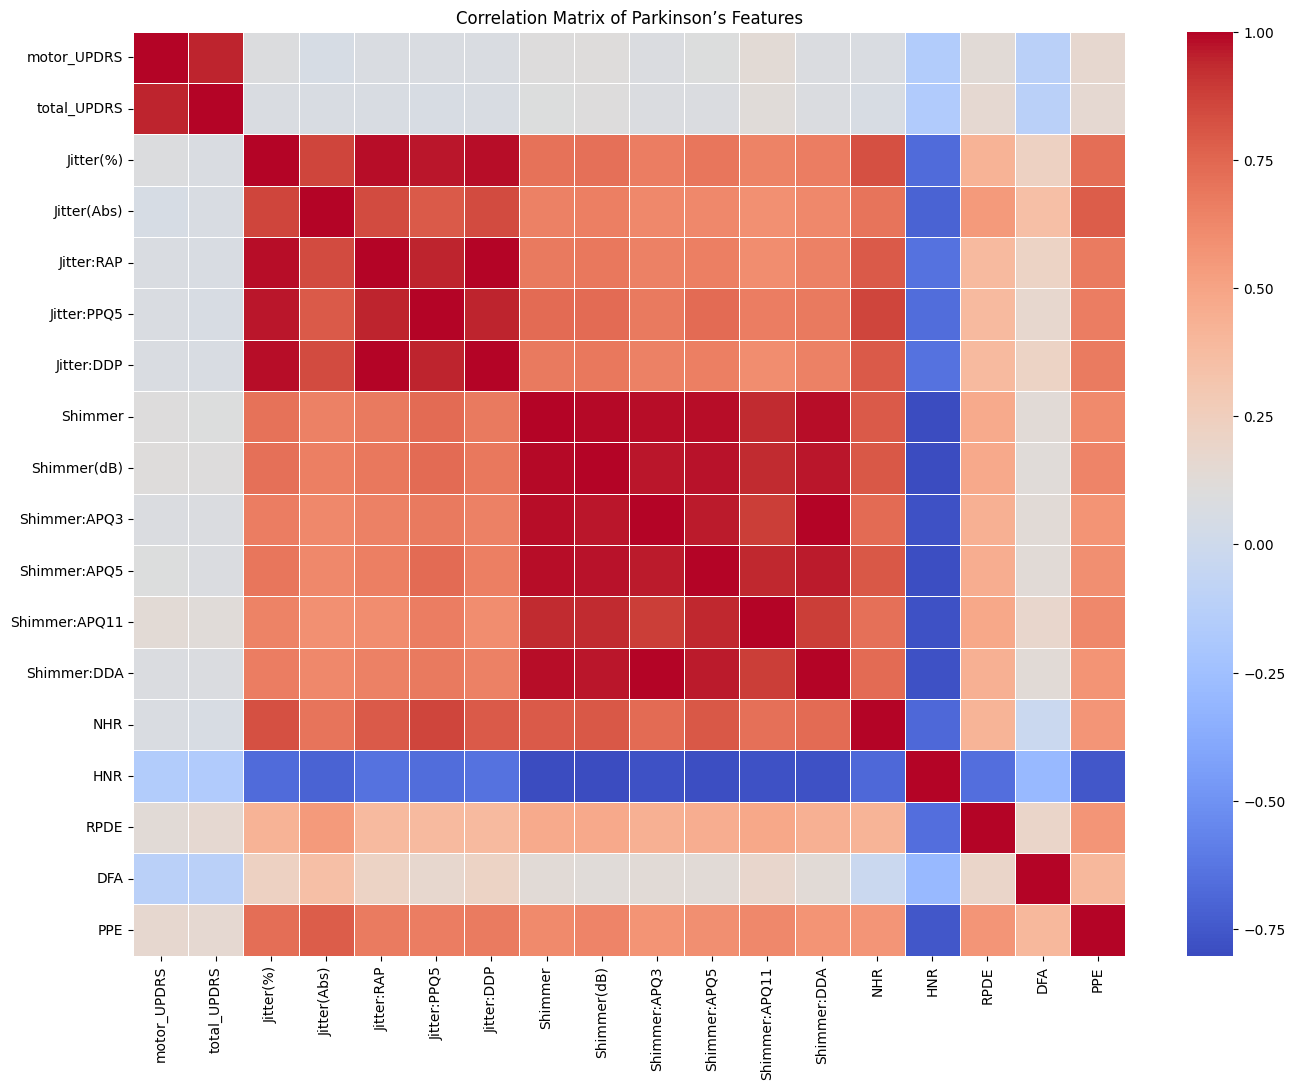

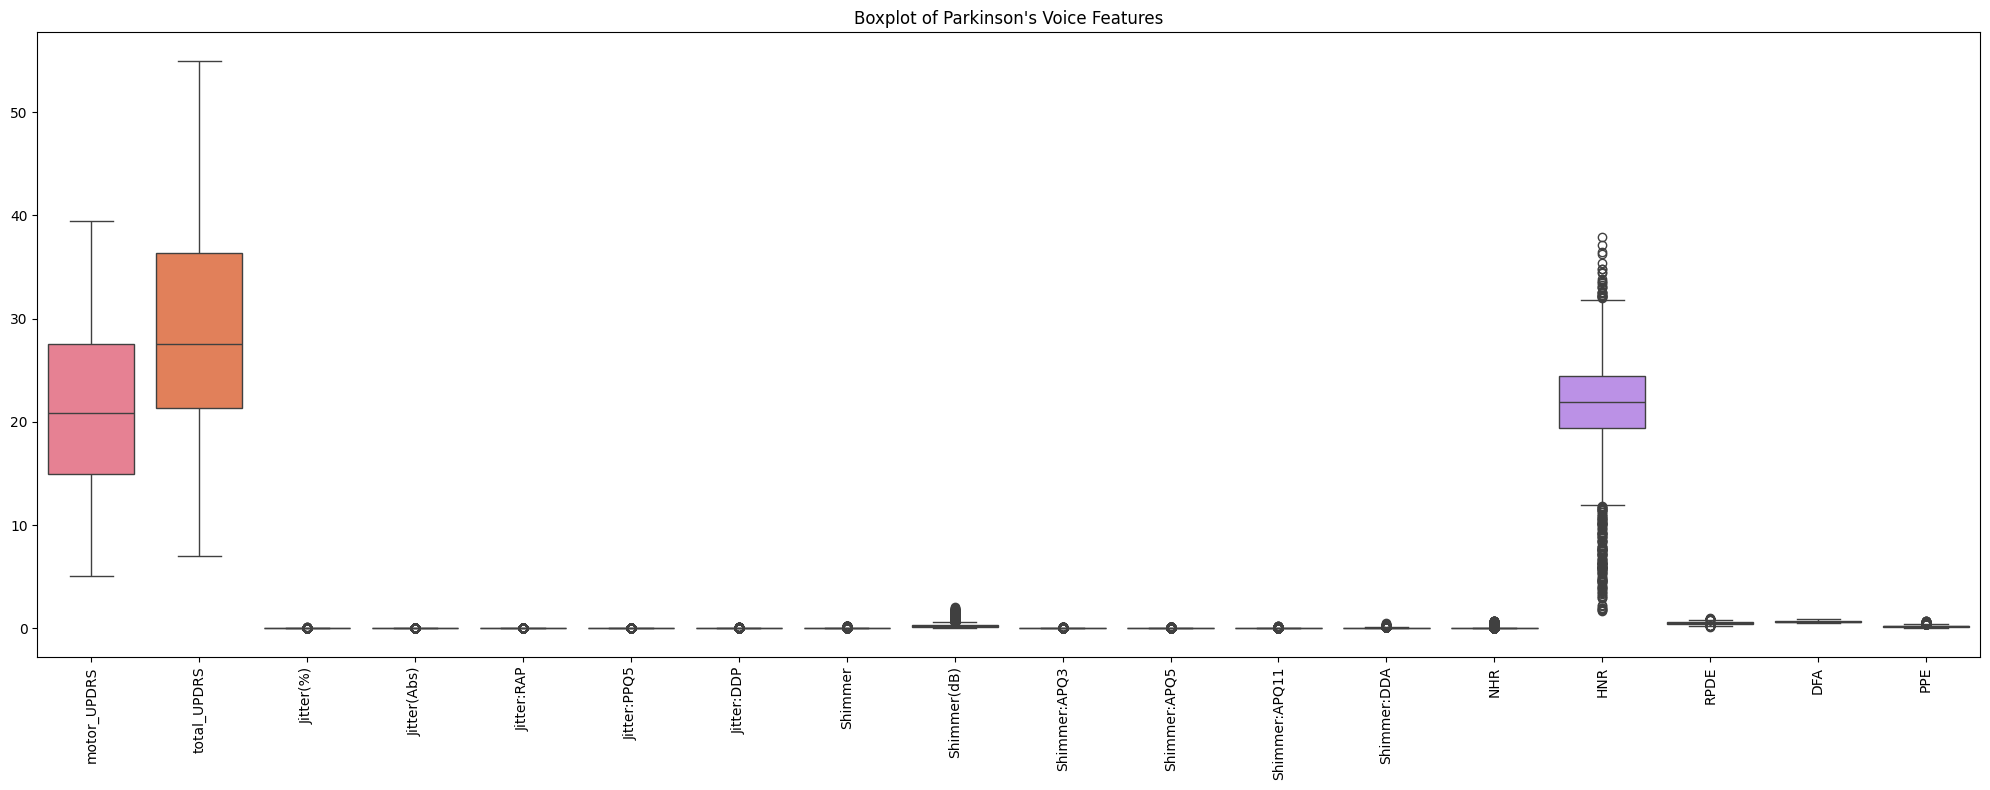

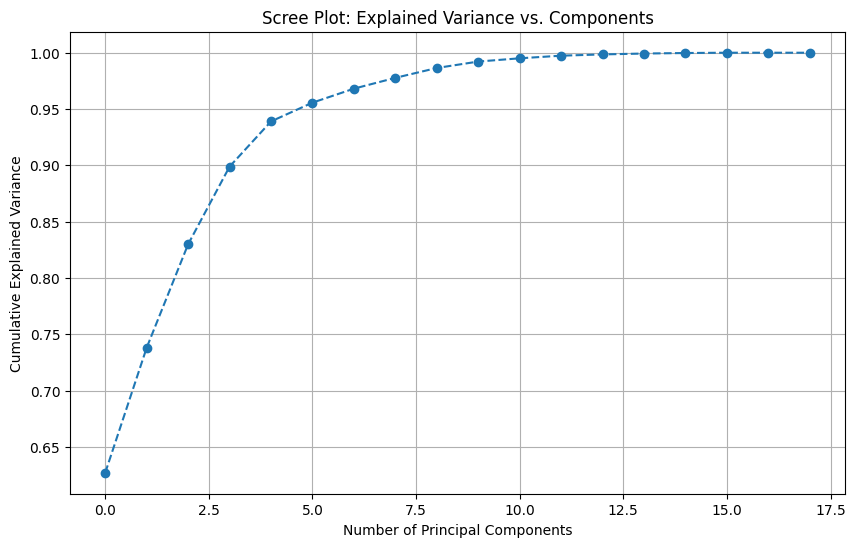

Number of components explaining 95% variance: 6


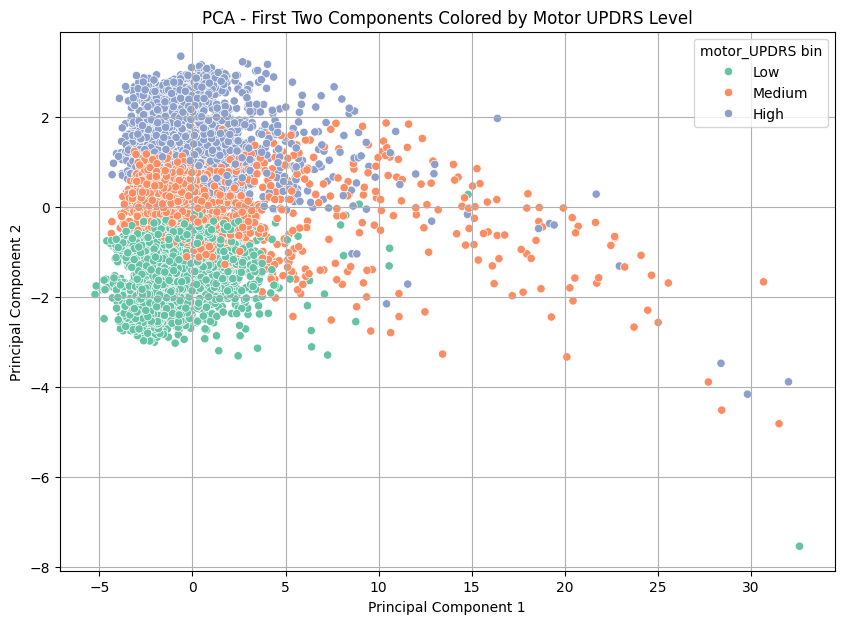

Linear Regression - MSE: 1.635
Linear Regression - R² Score: 0.974
Random Forest - MSE: 1.343
Random Forest - R² Score: 0.979


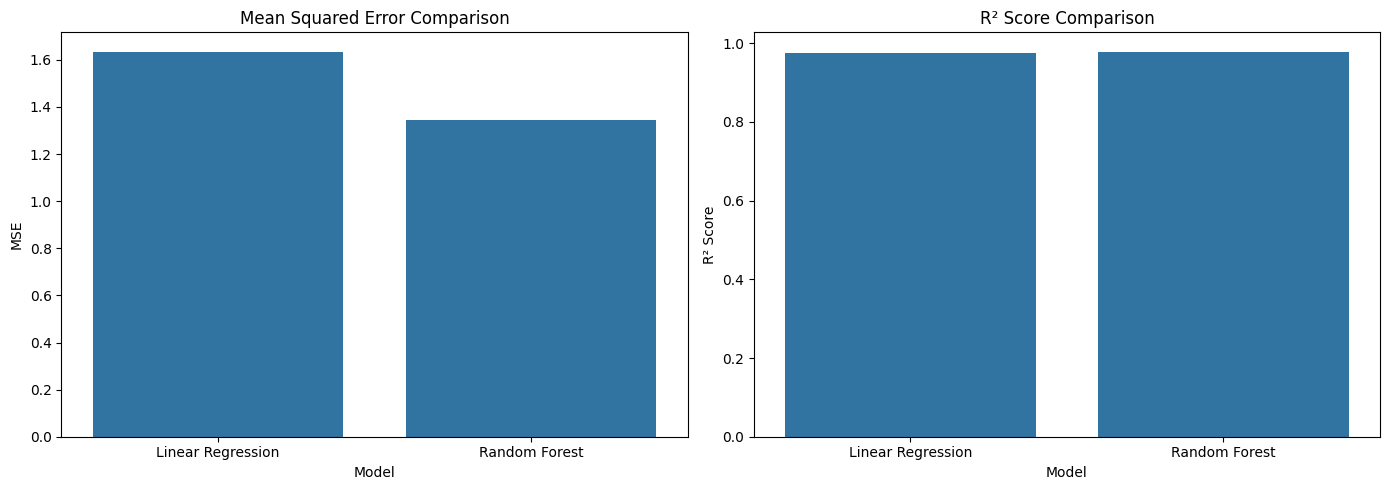

,Model,MSE,R² Score
0,Linear Regression,1.635209,0.974382
1,Random Forest,1.343177,0.978957


In [1]:

# 📦 Parkinson's Disease PCA + ML Analysis

# === Imports and Data Load ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("/content/parkinsons_updrs.csv")

# === Abbreviations and Feature Descriptions ===
feature_descriptions = {
    "Jitter(%)": "Frequency variation (%)",
    "Jitter(Abs)": "Absolute Jitter (s)",
    "Jitter:RAP": "Relative Average Perturbation",
    "Jitter:PPQ5": "Five-point Period Perturbation Quotient",
    "Jitter:DDP": "Difference of Differences of Periods",
    "Shimmer": "Amplitude variation",
    "Shimmer(dB)": "Amplitude variation (dB)",
    "Shimmer:APQ3": "Three-point Amplitude Perturbation Quotient",
    "Shimmer:APQ5": "Five-point Amplitude Perturbation Quotient",
    "Shimmer:APQ11": "Eleven-point Amplitude Perturbation Quotient",
    "Shimmer:DDA": "Average absolute difference between successive amplitude variations",
    "NHR": "Noise to Harmonics Ratio",
    "HNR": "Harmonics to Noise Ratio",
    "RPDE": "Recurrence Period Density Entropy (nonlinear dynamical complexity)",
    "DFA": "Detrended Fluctuation Analysis (signal fractal scaling)",
    "PPE": "Pitch Period Entropy (signal unpredictability)",
    "motor_UPDRS": "Motor score (target)",
    "total_UPDRS": "Total UPDRS score"
}
pd.DataFrame.from_dict(feature_descriptions, orient='index', columns=['Description'])

# === Correlation Matrix ===
feature_cols = df.drop(columns=["subject#", "age", "sex", "test_time"]).columns
correlation_matrix = df[feature_cols].corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Parkinson’s Features")
plt.show()

# === Boxplot for Distribution ===
plt.figure(figsize=(20, 8))
sns.boxplot(data=df[feature_cols])
plt.xticks(rotation=90)
plt.title("Boxplot of Parkinson's Voice Features")
plt.tight_layout()
plt.show()

# === Standardization ===
X = df[feature_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)

# === PCA and Scree Plot ===
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot: Explained Variance vs. Components')
plt.grid(True)
plt.show()

# === PCA Component Selection and Transformation ===
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components}")
pca_final = PCA(n_components=n_components)
X_reduced = pca_final.fit_transform(X_scaled)
pca_columns = [f'PC{i+1}' for i in range(n_components)]
X_pca_df = pd.DataFrame(X_reduced, columns=pca_columns)

# === 2D PCA Scatter Plot ===
df_copy = df.copy()
df_copy["motor_bin"] = pd.qcut(df_copy["motor_UPDRS"], q=3, labels=["Low", "Medium", "High"])
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca_df["PC1"], y=X_pca_df["PC2"], hue=df_copy["motor_bin"], palette="Set2")
plt.title("PCA - First Two Components Colored by Motor UPDRS Level")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="motor_UPDRS bin")
plt.grid(True)
plt.show()

# === Train-Test Split ===
y = df["motor_UPDRS"]
X_train, X_test, y_train, y_test = train_test_split(X_pca_df, y, test_size=0.2, random_state=42)

# === Linear Regression ===
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression - MSE: {mse_lr:.3f}")
print(f"Linear Regression - R² Score: {r2_lr:.3f}")

# === Random Forest Regressor ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - MSE: {mse_rf:.3f}")
print(f"Random Forest - R² Score: {r2_rf:.3f}")

# === Comparison Plot ===
metrics_df = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "MSE": [mse_lr, mse_rf],
    "R² Score": [r2_lr, r2_rf]
})
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(x="Model", y="MSE", data=metrics_df, ax=ax[0])
ax[0].set_title("Mean Squared Error Comparison")
sns.barplot(x="Model", y="R² Score", data=metrics_df, ax=ax[1])
ax[1].set_title("R² Score Comparison")
plt.tight_layout()
plt.show()

metrics_df
